In [99]:
import numpy as np
import scipy.io as scio    
import os,re
from scipy import ndimage
from scipy import misc
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

In [2]:
import keras

Using TensorFlow backend.


In [3]:
from keras.models import *
from keras.layers import Input,Flatten, Dense,merge, Conv2D, MaxPooling2D, UpSampling2D, Dropout, Cropping2D,Concatenate,Activation
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler,ReduceLROnPlateau,CSVLogger
from keras import backend as keras

In [4]:
def atoi(text) : 
    return int(text) if text.isdigit() else text

In [5]:
def natural_keys(text) :
    return [atoi(c) for c in re.split('(\d+)', text)]

In [6]:
total_images = np.load('total_images.npy')
ground_truth_images = np.load('gt_labels_binary.npy')

In [7]:
root_path = "/home/iplab/AI_assignment/cancer-prediction/"

In [8]:
def get_filenames(path):
    filenames = []
    for root, dirnames, filenames in os.walk(path):
        filenames.sort(key = natural_keys)
        rootpath = root
    print(len(filenames))
    return filenames

In [9]:
filenames_melanoma = get_filenames(root_path+"melanoma_resized/")
filenames_others = get_filenames(root_path+"others_resized/")

374
1626


In [10]:
filenames_total = filenames_melanoma+filenames_others
filenames_total.sort(key = natural_keys)

In [ ]:
segmented_images = np.copy(total_images)
x,y,z = segmented_images[0].shape
for i in range(len(total_images)):
    for j in range(x):
        for k in range(y):
            for l in range(z):
                segmented_images[i][j][k][l] = total_images[i][j][k][l] if ground_truth_images[i][j][k]==1 else 0
    misc.imsave(root_path+"segmented_images/segmented_"+filenames_total[i],segmented_images[i])

In [ ]:
segmented_images[0].shape

In [ ]:
total_images.shape

In [ ]:
ground_truth_images.shape

In [ ]:
np.save('segmented_images.npy',segmented_images)

In [11]:
segmented_images = np.load('segmented_images.npy')

In [12]:
classification_labels = np.zeros((len(total_images)))
i = 0
for file in filenames_total:
    if os.path.exists(root_path+"melanoma_resized/"+file):
        classification_labels[i]=0
    else:
        classification_labels[i]=1
    i+=1

In [13]:
print(classification_labels)

[ 1.  1.  0. ...,  1.  0.  1.]


In [14]:
np.save('classification_labels.npy',classification_labels)

In [15]:
train_indices = np.random.choice(2000,1900,replace=False)
print(len(train_indices))

1900


In [16]:
train_images = [segmented_images[i] for i in train_indices]
train_labels = [classification_labels[i] for i in train_indices]

In [17]:
print(len(train_images))
print(len(train_labels))

1900
1900


In [18]:
test_indices = [i for i in range(2000) if i not in train_indices]
print(len(test_indices))

100


In [19]:
test_images = [segmented_images[i] for i in test_indices]
test_labels = [classification_labels[i] for i in test_indices]

In [20]:
print(len(test_images))
print(len(test_labels))

100
100


In [21]:
plt.imshow(segmented_images[0])
plt.show()

In [22]:
print(classification_labels[0])

1.0


In [23]:
image_dims = segmented_images[0].shape
print(image_dims)

(128, 192, 3)


In [24]:
train_mean = np.mean(train_images,axis = (0,1,2,3))
train_std = np.std(train_images,axis = (0,1,2,3))
train_images = (train_images - train_mean)/(train_std+1e-7)

In [25]:
test_mean = np.mean(test_images,axis=(0,1,2,3))
test_std = np.std(test_images,axis = (0,1,2,3))
test_images = (test_images-test_mean)/(test_std+1e-7)

In [ ]:
np.save('classification_train_images.npy',train_images)
np.save('classification_test_images.npy',test_images)
np.save('classification_train_labels.npy',train_labels)
np.save('classification_test_labels.npy',test_labels)

In [26]:
train_images = np.load('classification_train_images.npy')
test_images = np.load('classification_test_images.npy')
train_labels = np.load('classification_train_labels.npy')
test_labels =  np.load('classification_test_labels.npy')

In [47]:
def get_unet_model(image_dims):
    inputs = Input((image_dims[0],image_dims[1],image_dims[2]))
    conv1 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
   

    up6 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv5))
    merge6 = Concatenate(axis=3)([conv4,up6])
    conv6 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = Concatenate(axis=3)([conv3,up7])
    conv7 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = Concatenate(axis=3)([conv2,up8])
    conv8 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = Concatenate(axis=3)([conv1,up9])
    conv9 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
  #  conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    #conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)
    flatten1 = Flatten()(conv9)
    dense2 = Dense(1,activation='sigmoid')(flatten1)
    
    model = Model(inputs = inputs, outputs = dense2)
    return model

In [48]:
model = get_unet_model((128,192,3))

In [49]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 128, 192, 3)       0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 128, 192, 16)      448       
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 128, 192, 16)      2320      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 64, 96, 16)        0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 64, 96, 32)        4640      
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 64, 96, 32)        9248      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 32, 48, 32)        0         
__________

In [52]:
model.compile(optimizer = Adam(lr = 1e-25), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [53]:
lr_reducer = ReduceLROnPlateau(factor=0.5, cooldown=0, patience=6, min_lr=0.5e-6)
csv_logger = CSVLogger('Unet_lr_e4_bs_10_classifier.csv')
model_checkpoint = ModelCheckpoint("Unet_lr_e4_bs_10_classifier.hdf5",monitor = 'val_loss',verbose = 1,save_best_only=True)

In [54]:
model.fit(train_images, train_labels, batch_size=10, epochs=20, verbose=1,validation_data=(test_images,test_labels), shuffle=True, callbacks=[lr_reducer,csv_logger,model_checkpoint])

Train on 1900 samples, validate on 100 samples
Epoch 1/20
1900/1900 [==============================] - 192s - loss: 0.5898 - acc: 0.8089 - val_loss: 0.5630 - val_acc: 0.8200
Epoch 2/20
1900/1900 [==============================] - 189s - loss: 0.5898 - acc: 0.8089 - val_loss: 0.5630 - val_acc: 0.8200
Epoch 3/20
1900/1900 [==============================] - 189s - loss: 0.5898 - acc: 0.8089 - val_loss: 0.5630 - val_acc: 0.8200
Epoch 4/20
1900/1900 [==============================] - 188s - loss: 0.5898 - acc: 0.8089 - val_loss: 0.5630 - val_acc: 0.8200
Epoch 5/20
1900/1900 [==============================] - 189s - loss: 0.5898 - acc: 0.8089 - val_loss: 0.5630 - val_acc: 0.8200
Epoch 6/20
1900/1900 [==============================] - 191s - loss: 0.5898 - acc: 0.8089 - val_loss: 0.5630 - val_acc: 0.8200
Epoch 7/20
1900/1900 [==============================] - 194s - loss: 0.5898 - acc: 0.8089 - val_loss: 0.5630 - val_acc: 0.8200
Epoch 8/20
1900/1900 [==============================] - 194s - l

In [59]:
plt.imshow(test_images[5])
plt.show()

In [60]:
test_images = np.expand_dims(test_images,axis=1)

In [62]:
sample_predictions = model.predict(test_images[5].reshape((1,128,192,3)))

In [74]:
predicted_class = sample_predictions[0]>0.5

In [75]:
predicted_class = 0 if predicted_class[0]==True else 1

In [81]:
predicted_class
print(type(predicted_class))

<type 'int'>


In [82]:
class_labels = {0:'melanoma',1:'others'}

In [83]:
print(class_labels[predicted_class])

melanoma


In [85]:
test_images = np.squeeze(test_images,axis=1)

In [86]:
test_predictions = model.predict(test_images)

In [91]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [92]:
class_names = ['melanoma','others']

In [94]:
test_labels

array([ 1.,  0.,  0.,  1.,  0.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,  1.,
        1.,  1.,  1.,  1.,  1.,  0.,  1.,  0.,  0.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,
        1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  0.,  1.,  1.,  1.,  0.,  1.,  1.,  0.,  1.,  1.,  0.,
        1.,  1.,  1.,  1.,  1.,  0.,  0.,  1.,  1.])

In [138]:
predicted_labels = np.zeros(test_predictions.shape[0])
for i in range(test_predictions.shape[0]):
    predicted_labels[i] = test_predictions[i]>0.72

In [139]:
predicted_labels.shape

(100,)

Confusion matrix, without normalization
[[10  8]
 [56 26]]
Normalized confusion matrix
[[ 0.56  0.44]
 [ 0.68  0.32]]


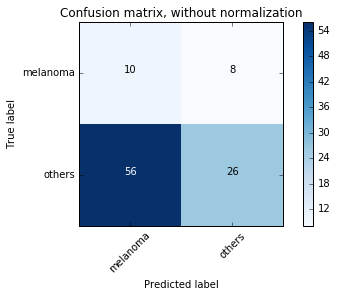

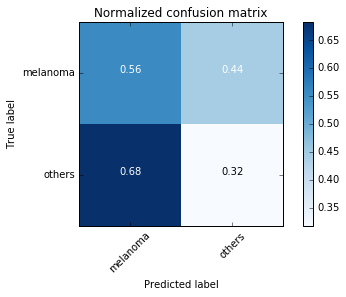

In [140]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(test_labels, predicted_labels)
np.set_printoptions(precision=2)
%matplotlib inline
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()